> Assign 0 for similarity if there is missing in either of the Fields 
(Also create another column which is 1 if either of the columns are missing)

In [1]:
import pandas as pd
import numpy as np
import libact
from libact.models import SVM
from libact.query_strategies import QUIRE, UncertaintySampling, RandomSampling, ActiveLearningByLearning, HintSVM
import warnings
import matplotlib.pyplot as plt
from libact.models import SklearnAdapter
from sklearn import tree
import seaborn as sbn
import time
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [3]:
from Utils import *
from Similarity import *

- Get the Data

In [4]:
phone_path ='/Users/bengikoseoglu/Documents/Masters/Semester4/Thesis/Notebooks/1_Merging/hp_merged.csv'
phone_result=pd.read_csv(phone_path)
phone_result.head()

Unnamed: 0                            id_webpage  match  \
0           0     node449b610bd3ad6439d1b26190266d5      0   
1           1  node4b4dee215b51f2eb45a114409ce7eda6      0   
2           2    node52a9f6bc8fa1772a0f6a2832641fa1      0   
3           3  node6d72a28b4e6d7d1aff11ebab95221fa1      0   
4           4     node88b5b595637fff2942878d19b2358      0   

  page_headphones_form_factor        page_mpn page_product_gtin  \
0      ear-cup (over the ear)  does not apply    does not apply   
1      ear-cup (over the ear)  does not apply    does not apply   
2                         NaN  does not apply    does not apply   
3      ear-cup (over the ear)  does not apply    does not apply   
4                         NaN  does not apply    does not apply   

              page_warc page_color page_brand page_model  \
0  ebay.com0.warc.nq.gz      black        akg   k712 pro   
1  ebay.com0.warc.nq.gz      black        akg   k712 pro   
2  ebay.com0.warc.nq.gz        NaN        akg   k712 pro   
3  ebay.com0.warc.nq.gz      black        akg   k712 pro   
4  ebay.com0.warc.nq.gz        NaN        akg        NaN   

                                            page_url  \
0  http://www.ebay.com/itm/brand-new-akg-k712-pro...   
1  http://www.ebay.com/itm/brand-new-akg-k712-pro...   
2  http://www.ebay.com/itm/brand-new-akg-k712-pro...   
3  http://www.ebay.com/itm/brand-new-akg-k712-pro...   
4  http://www.ebay.com/itm/brand-new-akg-k712-pro...   

  page_connectivity_technology page_series page_sensitivity page_product_type  \
0                          NaN         NaN              NaN               NaN   
1                          NaN         NaN              NaN               NaN   
2                          NaN         NaN              NaN               NaN   
3                          NaN         NaN              NaN               NaN   
4                          NaN    k712 pro              NaN               NaN   

  page_headphones_technology page_weight page_frequency_response  \
0                        NaN         NaN                     NaN   
1                        NaN         NaN                     NaN   
2                        NaN         NaN                     NaN   
3                        NaN         NaN                     NaN   
4                        NaN         NaN                     NaN   

  page_impedance page_compatibility page_thd page_included_accessories  \
0        62 ohms                NaN      NaN                       NaN   
1        62 ohms                NaN      NaN                       NaN   
2            NaN                NaN      NaN                       NaN   
3        62 ohms                NaN      NaN                       NaN   
4            NaN                NaN      NaN                       NaN   

  page_warranty page_microphone_sensitivity page_height page_microphone  \
0           NaN                         NaN         NaN             NaN   
1           NaN                         NaN         NaN             NaN   
2           NaN                         NaN         NaN             NaN   
3           NaN                         NaN         NaN             NaN   
4           NaN                         NaN         NaN             NaN   

  page_headphones_cup_type page_max_input_power page_width  \
0            open-air type                  NaN        NaN   
1            open-air type                  NaN        NaN   
2            open-air type                  NaN        NaN   
3            open-air type                  NaN        NaN   
4            open-air type                  NaN        NaN   

  page_cables_included page_magnet_material cat_headphones_technology  \
0                  NaN                  NaN                   dynamic   
1                  NaN                  NaN                   dynamic   
2                  NaN                  NaN                   dynamic   
3                  NaN                  NaN                   dynamic   

In [5]:
phone_result.shape

(23087, 71)

- Choose attributes

 not usable:
 Unnamed: 0
 id_webpage
 prodcat_id
 page_url
 page_warc 
 prodcat_product_name

 match

 no matches: 
 cat_voltage
 cat_package_height
 cat_core_count
 cat_power_supply

 page_product_type -> cat_product_type
 page_mpn -> cat_mpn
 page_brand -> cat_brand
 page_phone_type -> cat_product_type
 page_computer_operating_system -> cat_computer_operating_system
 page_memory -> cat_memory
 page_depth -> cat_depth
 page_product_grin -> cat_product_gtin
 page_rear_cam_resolution -> cat_rear_cam_resolution
 page_height -> cat_height
 page_phone_carrier -> cat_phone_carrier
 page_ram -> cat_ram
 page_dimensions -> cat_dimensions
 page_front_cam_resolution -> cat_front_cam_resolution
 page_body_material -> cat_body_material
 page_color -> cat_color
 page_display_size -> cat_display_size
 page_processor_type -> cat_processor_type
 page_weight -> cat_weight
 page_display_resolution -> cat_display_resolution
 page_width -> cat_width

 page_wattage -> cat_wattage (MISSING)
 page_product_code -> cat_product_code (MISSING)
 page_manufacturer -> cat_manufacturer (MISSING)
 page_modelnum -> cat_modelnum. (MISSING)


In [6]:
# columns that only exist in pages
only_page_columns=[]
print(len(only_page_columns))

0


In [7]:
# columns that only exist in catalog
only_cat_columns=['cat_controls', 'cat_compliant_standards', 'cat_diaphragm', 'cat_foldable', 'cat_depth', 'cat_microphone_response', 'cat_detachable_cable', 'cat_sound_output_mode', 'cat_microphone_audio_details', 'cat_aditional_features','cat_mdoel']
print(len(only_cat_columns))

11


In [8]:
# columns that are ids, target and matching attributes
matches=['id_webpage','prodcat_id', 'page_url', 'page_warc', 'prodcat_product_name','match','cat_product_gtin','page_product_gtin', 'cat_product_type', 'page_product_type','cat_model','page_model','cat_brand', 'page_brand', 'cat_microphone', 'page_microphone','cat_connectivity_technology','page_connectivity_technology', 'cat_thd','page_thd', 'cat_warranty', 'page_warranty', 'cat_headphones_form_factor', 'page_headphones_form_factor', 'cat_included_accessories', 'page_included_accessories', 'cat_impedance', 'page_impedance', 'cat_frequency_response', 'page_frequency_response', 'cat_magnet_material', 'page_magnet_material', 'cat_compatibility', 'page_compatibility', 'cat_cables_included', 'page_cables_included', 'cat_mpn', 'page_mpn', 'cat_weight', 'page_weight', 'cat_height', 'page_height', 'cat_width', 'page_width', 'cat_headphones_cup_type','page_headphones_cup_type', 'cat_headphones_technology', 'page_headphones_technology', 'cat_max_input_power', 'page_max_input_power', 'cat_microphone_sensitivity', 'page_microphone_sensitivity', 'cat_sensitivity', 'page_sensitivity', 'cat_color', 'page_color', 'cat_series', 'page_series']
print(len(matches))

58


In [9]:
cols_inorder= matches.copy()
cols_inorder.extend(only_cat_columns)
cols_inorder.extend(only_page_columns)
phone_result_sub=phone_result[cols_inorder]
phone_result_sub.head()

id_webpage                            prodcat_id  \
0     node449b610bd3ad6439d1b26190266d5  d7130c90-df60-4e0d-a898-ad8e2821dc7f   
1  node4b4dee215b51f2eb45a114409ce7eda6  d7130c90-df60-4e0d-a898-ad8e2821dc7f   
2    node52a9f6bc8fa1772a0f6a2832641fa1  d7130c90-df60-4e0d-a898-ad8e2821dc7f   
3  node6d72a28b4e6d7d1aff11ebab95221fa1  d7130c90-df60-4e0d-a898-ad8e2821dc7f   
4     node88b5b595637fff2942878d19b2358  d7130c90-df60-4e0d-a898-ad8e2821dc7f   

                                            page_url             page_warc  \
0  http://www.ebay.com/itm/brand-new-akg-k712-pro...  ebay.com0.warc.nq.gz   
1  http://www.ebay.com/itm/brand-new-akg-k712-pro...  ebay.com0.warc.nq.gz   
2  http://www.ebay.com/itm/brand-new-akg-k712-pro...  ebay.com0.warc.nq.gz   
3  http://www.ebay.com/itm/brand-new-akg-k712-pro...  ebay.com0.warc.nq.gz   
4  http://www.ebay.com/itm/brand-new-akg-k712-pro...  ebay.com0.warc.nq.gz   

      prodcat_product_name  match cat_product_gtin page_product_gtin  \
0  audio technica ath-m50x      0   04961310125431    does not apply   
1  audio technica ath-m50x      0   04961310125431    does not apply   
2  audio technica ath-m50x      0   04961310125431    does not apply   
3  audio technica ath-m50x      0   04961310125431    does not apply   
4  audio technica ath-m50x      0   04961310125431    does not apply   

  cat_product_type page_product_type cat_model page_model       cat_brand  \
0       headphones               NaN  ath-m50x   k712 pro  audio-technica   
1       headphones               NaN  ath-m50x   k712 pro  audio-technica   
2       headphones               NaN  ath-m50x   k712 pro  audio-technica   
3       headphones               NaN  ath-m50x   k712 pro  audio-technica   
4       headphones               NaN  ath-m50x        NaN  audio-technica   

  page_brand cat_microphone page_microphone cat_connectivity_technology  \
0        akg            NaN             NaN                       wired   
1        akg            NaN             NaN                       wired   
2        akg            NaN             NaN                       wired   
3        akg            NaN             NaN                       wired   
4        akg            NaN             NaN                       wired   

  page_connectivity_technology cat_thd page_thd cat_warranty page_warranty  \
0                          NaN     NaN      NaN     2 years            NaN   
1                          NaN     NaN      NaN     2 years            NaN   
2                          NaN     NaN      NaN     2 years            NaN   
3                          NaN     NaN      NaN     2 years            NaN   
4                          NaN     NaN      NaN     2 years            NaN   

  cat_headphones_form_factor page_headphones_form_factor  \
0     full size, circumaural      ear-cup (over the ear)   
1     full size, circumaural      ear-cup (over the ear)   
2     full size, circumaural                         NaN   
3     full size, circumaural      ear-cup (over the ear)   
4     full size, circumaural                         NaN   

                         cat_included_accessories page_included_accessories  \
0  headphones pouch, 6.3 mm (1/4") stereo adapter                       NaN   
1  headphones pouch, 6.3 mm (1/4") stereo adapter                       NaN   
2  headphones pouch, 6.3 mm (1/4") stereo adapter                       NaN   
3  headphones pouch, 6.3 mm (1/4") stereo adapter                       NaN   
4  headphones pouch, 6.3 mm (1/4") stereo adapter                       NaN   

  cat_impedance page_impedance cat_frequency_response page_frequency_response  \
0        38 ohm        62 ohms          15 - 28000 hz                     NaN   
1        38 ohm        62 ohms          15 - 28000 hz                     NaN   
2        38 ohm            NaN          15 - 28000 hz                     NaN   
3        38 ohm        62 ohms          15 - 28000 hz                     NaN   
4        38 ohm 

In [10]:
print(len(phone_result_sub.columns))
print(len(set(phone_result_sub.columns)))

69
69


- Look at missing values

In [11]:
phone_result_stat=get_stats_table(phone_result_sub,only_page_columns,only_cat_columns)
phone_result_stat.to_excel('phone_result_stats.xlsx')
print(phone_result_stat.shape)

(69, 8)


In [12]:
phone_result_stat

count  no_unique  no_missing  percent_missing  \
column_name                                                                   
id_webpage                    23087        444           0            0.000   
prodcat_id                    23087         50           0            0.000   
page_url                      23087        444           0            0.000   
page_warc                     23087          8           0            0.000   
prodcat_product_name          23087         49           0            0.000   
match                         23087          2           0            0.000   
cat_product_gtin              22199         47         888            0.038   
page_product_gtin              2443          7       20644            0.894   
cat_product_type              23087          6           0            0.000   
page_product_type              1612          7       21475            0.930   
cat_model                     22643         48         444            0.019   
page_model                    15755         73        7332            0.318   
cat_brand                     23087          6           0            0.000   
page_brand                    15963         23        7124            0.309   
cat_microphone                 1776          1       21311            0.923   
page_microphone                  52          1       23035            0.998   
cat_connectivity_technology   22643          3         444            0.019   
page_connectivity_technology   5668         20       17419            0.754   
cat_thd                       10212         13       12875            0.558   
page_thd                       2444         12       20643            0.894   
cat_warranty                  13763          5        9324            0.404   
page_warranty                  1404          3       21683            0.939   
cat_headphones_form_factor    23087          8           0            0.000   
page_headphones_form_factor    9879         56       13208            0.572   
cat_included_accessories      20423         23        2664            0.115   
page_included_accessories      1872         10       21215            0.919   
cat_impedance                 22199         24         888            0.038   
page_impedance                 5511         27       17576            0.761   
cat_frequency_response        23087         37           0            0.000   
page_frequency_response        3536         26       19551            0.847   
...                             ...        ...         ...              ...   
page_weight                    3380         28       19707            0.854   
cat_height                     1332          3       21755            0.942   
page_height                     312          2       22775            0.986   
cat_width                      1332          3       21755            0.942   
page_width                      208          1       22879            0.991   
cat_headphones_cup_type        5328          6       17759            0.769   
page_headphones_cup_type       1143          6       21944            0.950   
cat_headphones_technology     17315          2        5772            0.250   
page_headphones_technology     2756         13       20331            0.881   
cat_max_input_power            2220          3       20867            0.904   
page_max_input_power            312          3       22775            0.986   
cat_microphone_sensitivity    12432         20       10655            0.462   
page_microphone_sensitivity    1404          6       21683            0.939   
cat_sensitivity               20867         32        2220            0.096   
page_sensitivity               5408         33       17679            0.766   
cat_color                      7991          8       15096            0.654   
page_color                    10555         23       12532            0.543   
cat_series                    18647         18        4440            0.192   
p

- Drop missing values

(There are no column with full missing values in headphones)

In [13]:
full_missing_columns=list(phone_result_stat[phone_result_stat['percent_missing']==1].index)
print(full_missing_columns)

[]


In [14]:
# find missing values correspodence in pages and category
page_col_drop=['page_'+i[4:] for i in full_missing_columns]
cat_col_drop=['cat_'+i[4:] for i in full_missing_columns]
cat_col_drop.extend(page_col_drop)
print(cat_col_drop)

[]


In [15]:
# check whether every column exists
df_columns=list(phone_result_sub.columns)
new_drop=[]
for i in cat_col_drop:
    if(i in df_columns):
        new_drop.append(i)
new_drop

[]

In [16]:
# actually drop them
phone_result_sub=phone_result_sub.drop(new_drop,axis=1)
print(phone_result_sub.shape)
print(phone_result_sub.columns)

(23087, 69)
Index(['id_webpage', 'prodcat_id', 'page_url', 'page_warc',
       'prodcat_product_name', 'match', 'cat_product_gtin',
       'page_product_gtin', 'cat_product_type', 'page_product_type',
       'cat_model', 'page_model', 'cat_brand', 'page_brand', 'cat_microphone',
       'page_microphone', 'cat_connectivity_technology',
       'page_connectivity_technology', 'cat_thd', 'page_thd', 'cat_warranty',
       'page_warranty', 'cat_headphones_form_factor',
       'page_headphones_form_factor', 'cat_included_accessories',
       'page_included_accessories', 'cat_impedance', 'page_impedance',
       'cat_frequency_response', 'page_frequency_response',
       'cat_magnet_material', 'page_magnet_material', 'cat_compatibility',
       'page_compatibility', 'cat_cables_included', 'page_cables_included',
       'cat_mpn', 'page_mpn', 'cat_weight', 'page_weight', 'cat_height',
       'page_height', 'cat_width', 'page_width', 'cat_headphones_cup_type',
       'page_headphones_cup_type',

- Drop variables only in the categories, if they still exist

In [17]:
# check whether only category columns are still exist or not
df_columns=list(phone_result_sub.columns)
new_drop=[]
for i in only_cat_columns:
    if(i in df_columns):
        new_drop.append(i)
new_drop

['cat_controls',
 'cat_compliant_standards',
 'cat_diaphragm',
 'cat_foldable',
 'cat_depth',
 'cat_microphone_response',
 'cat_detachable_cable',
 'cat_sound_output_mode',
 'cat_microphone_audio_details',
 'cat_aditional_features',
 'cat_mdoel']

In [18]:
phone_result_sub=phone_result_sub.drop(new_drop,axis=1)
print(phone_result_sub.shape)

(23087, 58)


- Drop unneccesary ids

In [19]:
# drop further ids
drop_2=['page_url', 'page_warc','prodcat_product_name']
phone_result_sub=phone_result_sub.drop(drop_2,axis=1)
print(phone_result_sub.shape)

(23087, 55)


- calculate similarities (jaccard, levenstein, jaro-winkler)

In [20]:
page_columns=get_clean_collist(phone_result_sub, 'page')
cat_columns=get_clean_collist(phone_result_sub, 'cat')
jac_columns_el=get_clean_collist(phone_result_sub, 'jac')
lev_columns_el =get_clean_collist(phone_result_sub, 'lev')
jaro_columns_el =get_clean_collist(phone_result_sub, 'jaro')
miss_columns =get_clean_collist(phone_result_sub, 'miss')
p_result_nomiss=calculate_similarities_option3(phone_result_sub,page_columns,cat_columns,jac_columns_el,lev_columns_el,jaro_columns_el,miss_columns)
p_result_nomiss.head()

id_webpage                            prodcat_id  \
0     node449b610bd3ad6439d1b26190266d5  d7130c90-df60-4e0d-a898-ad8e2821dc7f   
1  node4b4dee215b51f2eb45a114409ce7eda6  d7130c90-df60-4e0d-a898-ad8e2821dc7f   
2    node52a9f6bc8fa1772a0f6a2832641fa1  d7130c90-df60-4e0d-a898-ad8e2821dc7f   
3  node6d72a28b4e6d7d1aff11ebab95221fa1  d7130c90-df60-4e0d-a898-ad8e2821dc7f   
4     node88b5b595637fff2942878d19b2358  d7130c90-df60-4e0d-a898-ad8e2821dc7f   

   match cat_product_gtin page_product_gtin cat_product_type  \
0      0   04961310125431    does not apply       headphones   
1      0   04961310125431    does not apply       headphones   
2      0   04961310125431    does not apply       headphones   
3      0   04961310125431    does not apply       headphones   
4      0   04961310125431    does not apply       headphones   

  page_product_type cat_model page_model       cat_brand page_brand  \
0               NaN  ath-m50x   k712 pro  audio-technica        akg   
1               NaN  ath-m50x   k712 pro  audio-technica        akg   
2               NaN  ath-m50x   k712 pro  audio-technica        akg   
3               NaN  ath-m50x   k712 pro  audio-technica        akg   
4               NaN  ath-m50x        NaN  audio-technica        akg   

  cat_microphone page_microphone cat_connectivity_technology  \
0            NaN             NaN                       wired   
1            NaN             NaN                       wired   
2            NaN             NaN                       wired   
3            NaN             NaN                       wired   
4            NaN             NaN                       wired   

  page_connectivity_technology cat_thd page_thd cat_warranty page_warranty  \
0                          NaN     NaN      NaN     2 years            NaN   
1                          NaN     NaN      NaN     2 years            NaN   
2                          NaN     NaN      NaN     2 years            NaN   
3                          NaN     NaN      NaN     2 years            NaN   
4                          NaN     NaN      NaN     2 years            NaN   

  cat_headphones_form_factor page_headphones_form_factor  \
0     full size, circumaural      ear-cup (over the ear)   
1     full size, circumaural      ear-cup (over the ear)   
2     full size, circumaural                         NaN   
3     full size, circumaural      ear-cup (over the ear)   
4     full size, circumaural                         NaN   

                         cat_included_accessories page_included_accessories  \
0  headphones pouch, 6.3 mm (1/4") stereo adapter                       NaN   
1  headphones pouch, 6.3 mm (1/4") stereo adapter                       NaN   
2  headphones pouch, 6.3 mm (1/4") stereo adapter                       NaN   
3  headphones pouch, 6.3 mm (1/4") stereo adapter                       NaN   
4  headphones pouch, 6.3 mm (1/4") stereo adapter                       NaN   

  cat_impedance page_impedance cat_frequency_response page_frequency_response  \
0        38 ohm        62 ohms          15 - 28000 hz                     NaN   
1        38 ohm        62 ohms          15 - 28000 hz                     NaN   
2        38 ohm            NaN          15 - 28000 hz                     NaN   
3        38 ohm        62 ohms          15 - 28000 hz                     NaN   
4        38 ohm            NaN          15 - 28000 hz                     NaN   

  cat_magnet_material page_magnet_material cat_compatibility  \
0           neodymium                  NaN               NaN   
1           neodymium                  NaN               NaN   
2           neodymium                  NaN               NaN   
3           neodymium                  NaN               NaN   
4           neodymium                  NaN               NaN   

  page_compatibility                                cat_cables_included  \
0                NaN  2 x headphones cable - external - 10 ft headph...   
1                N

In [21]:
df2=p_result_nomiss.copy()

In [22]:
cols_all = jac_columns_el.copy()
cols_all.extend(lev_columns_el)
cols_all.extend(jaro_columns_el)
cols_all.extend(miss_columns)
cols_all.append('match')

- Calculate heat matrix between target and different string matching methods

In [28]:
corrmat = p_result_nomiss.corr()

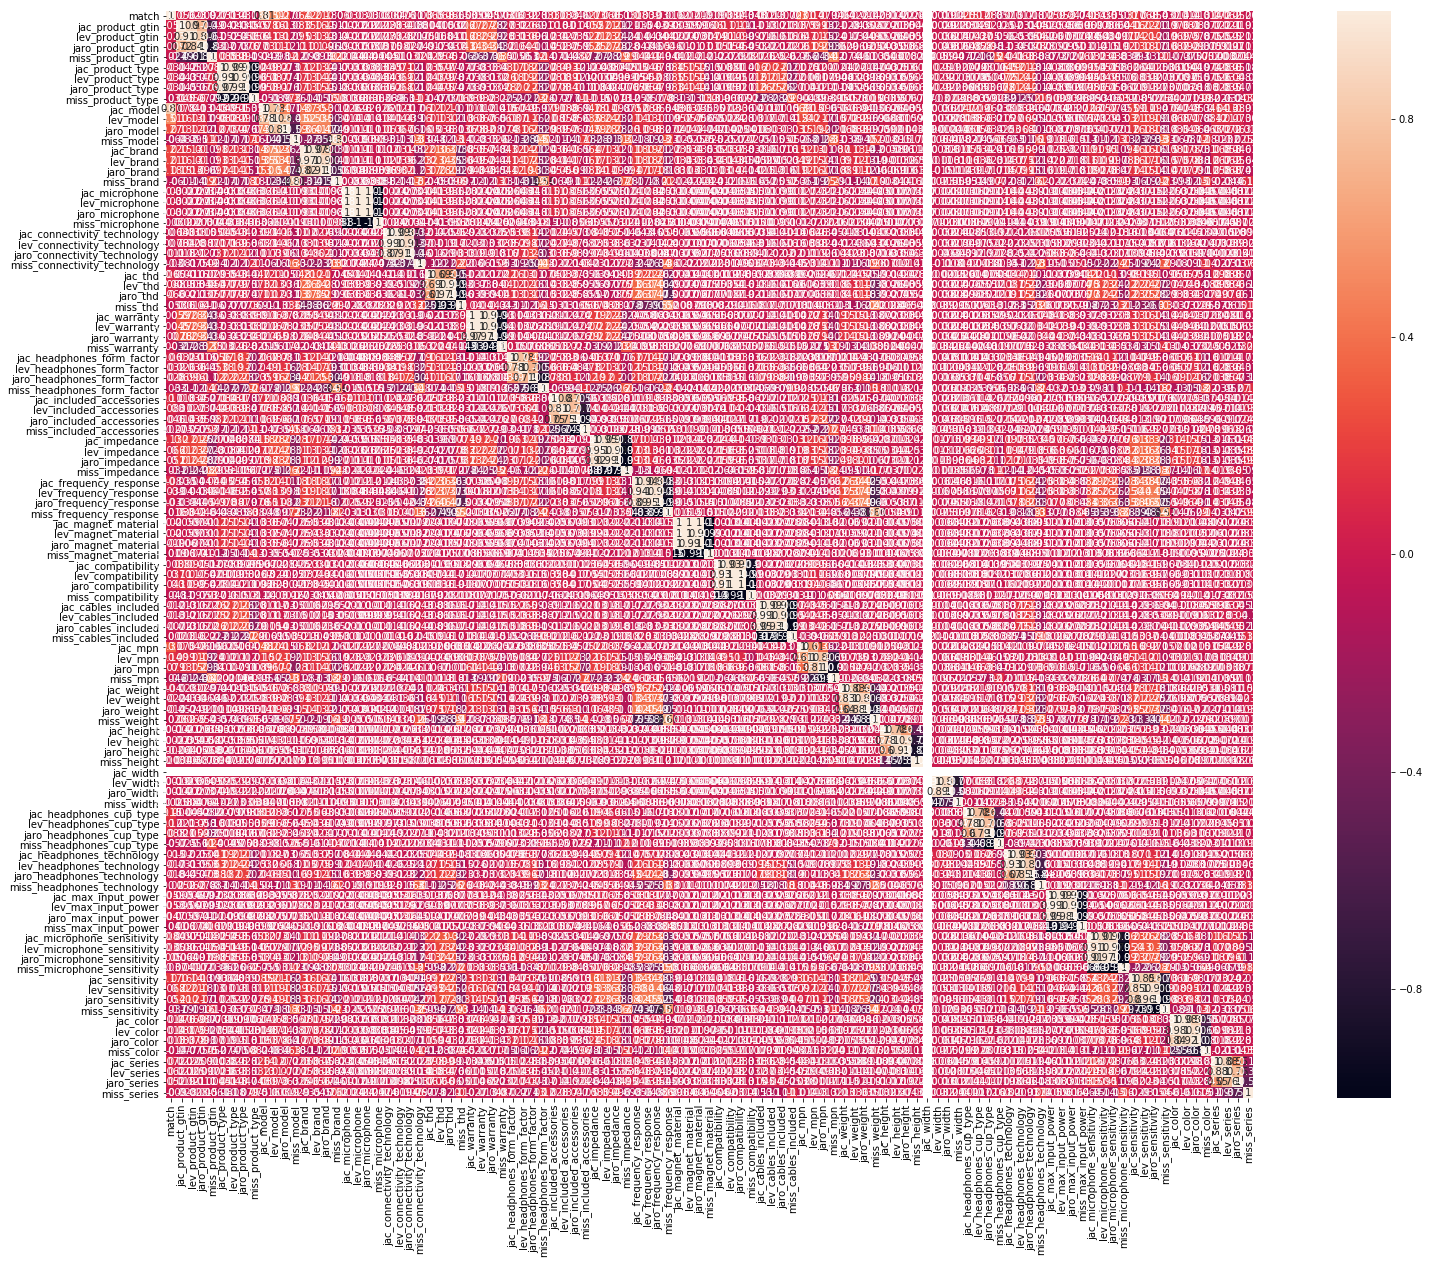

In [29]:
f, ax = plt.subplots(figsize=(30, 20))
sbn.heatmap(corrmat, vmax=1, cbar=True, annot=True, square=True)
plt.show()

# 1. USING ONLY JACCARD

- Modeling Parameters

In [31]:
cols = jac_columns_el.copy()
cols.extend(miss_columns)

In [33]:
# take all the columns
p_result_nomiss_jac=df2[cols_all]
# do train, test split
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)
seed=10
# get the seeds from clusters
samp=get_seed_cluster(y_train, X_train, seed)[0]

# filter the train and test according to its columns
X_train = np.array(pd.DataFrame(X_train).iloc[:,get_columns(cols_all, cols)])
X_test = np.array(pd.DataFrame(X_test).iloc[:,get_columns(cols_all, cols)])

trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds = Dataset(X_test, y_test)


In [34]:
X_train.shape

(15468, 52)

In [36]:
run_=10
missing_option='opt3'
features='onlyjac'

In [41]:
cols

['jac_product_gtin',
 'jac_product_type',
 'jac_model',
 'jac_brand',
 'jac_microphone',
 'jac_connectivity_technology',
 'jac_thd',
 'jac_warranty',
 'jac_headphones_form_factor',
 'jac_included_accessories',
 'jac_impedance',
 'jac_frequency_response',
 'jac_magnet_material',
 'jac_compatibility',
 'jac_cables_included',
 'jac_mpn',
 'jac_weight',
 'jac_height',
 'jac_width',
 'jac_headphones_cup_type',
 'jac_headphones_technology',
 'jac_max_input_power',
 'jac_microphone_sensitivity',
 'jac_sensitivity',
 'jac_color',
 'jac_series',
 'miss_product_gtin',
 'miss_product_type',
 'miss_model',
 'miss_brand',
 'miss_microphone',
 'miss_connectivity_technology',
 'miss_thd',
 'miss_warranty',
 'miss_headphones_form_factor',
 'miss_included_accessories',
 'miss_impedance',
 'miss_frequency_response',
 'miss_magnet_material',
 'miss_compatibility',
 'miss_cables_included',
 'miss_mpn',
 'miss_weight',
 'miss_height',
 'miss_width',
 'miss_headphones_cup_type',
 'miss_headphones_technology

- Model Results (pure)

In [37]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log, tn_log, fp_log, fn_log, tp_log = get_base_model_result(y_test, y_train, X_test, X_train, ls())
print(f1_score_log)
print(tn_log)
print(fp_log)
print(fn_log)
print(tp_log)

0.8939393939393939
7546
3
11
59


In [38]:
from sklearn.svm import SVC as support_vector
f1_score_svm, tn_svm, fp_svm, fn_svm, tp_svm = get_base_model_result(y_test, y_train, X_test, X_train, support_vector())
print(f1_score_svm)
print(tn_svm)
print(fp_svm)
print(fn_svm)
print(tp_svm)

0.9007633587786259
7547
2
11
59


In [39]:
from sklearn import tree
f1_score_dt, tn_dt, fp_dt, fn_dt, tp_dt = get_base_model_result(y_test, y_train, X_test, X_train, tree.DecisionTreeClassifier())
print(f1_score_dt)
print(tn_dt)
print(fp_dt)
print(fn_dt)
print(tp_dt)

0.9343065693430657
7546
3
6
64


In [40]:
f1_score_rf, tn_rf, fp_rf, fn_rf, tp_rf = get_base_model_result(y_test, y_train, X_test, X_train, RandomForestClassifier())
print(f1_score_rf)
print(tn_rf)
print(fp_rf)
print(fn_rf)
print(tp_rf)

0.923076923076923
7549
0
10
60


## 1.1. Random Sampling

In [45]:
q_type='random'

### 1.1.1. Logistic Regression

In [46]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_log, iter_r_log, f1score_r_log, tn_r_log, fp_r_log,fn_r_log, tp_r_log, k_r_log, trn_dss_r_log, label_holder_r_log, asked_id_r_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8939393939393939
Current progress: 100.0 %
348.02207016944885


(0, 1)

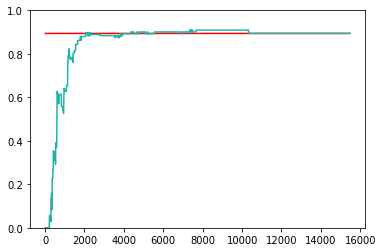

In [47]:
plt.plot(q_r_log, [f1_score_log] * (len(q_r_log)), '-r')
plt.plot(q_r_log, f1score_r_log,'lightseagreen')
plt.ylim(0, 1)

### 1.1.2. Support Vector Machine

In [48]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_svm, iter_r_svm, f1score_r_svm, tn_r_svm, fp_r_svm,fn_r_svm, tp_r_svm, k_r_svm, trn_dss_r_svm, label_holder_r_svm, asked_id_r_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9007633587786259
Current progress: 100.0 %
683.220086812973


(0, 1)

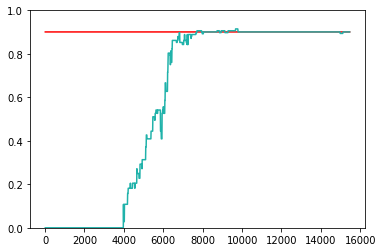

In [49]:
plt.plot(q_r_svm, [f1_score_svm] * (len(q_r_svm)), '-r')
plt.plot(q_r_svm, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

### 1.1.3. Decision Tree

In [50]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_dt, iter_r_dt, f1score_r_dt, tn_r_dt, fp_r_dt,fn_r_dt, tp_r_dt, k_r_dt, trn_dss_r_dt, label_holder_r_dt, asked_id_r_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9635036496350364
Current progress: 100.0 %
344.52180457115173


(0, 1)

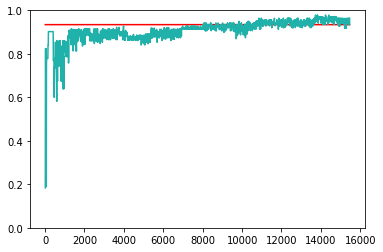

In [51]:
plt.plot(q_r_dt, [f1_score_dt] * (len(q_r_dt)), '-r')
plt.plot(q_r_dt, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 1.1.4. Random Forest Regression

In [52]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_rf, iter_r_rf, f1score_r_rf, tn_r_rf, fp_r_rf,fn_r_rf, tp_r_rf, k_r_rf, trn_dss_r_rf, label_holder_r_rf, asked_id_r_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9473684210526316
Current progress: 100.0 %
351.43653202056885


(0, 1)

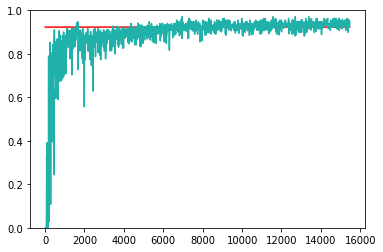

In [53]:
plt.plot(q_r_rf, [f1_score_rf] * (len(q_r_rf)), '-r')
plt.plot(q_r_rf, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

## 1.2. Uncertainity Sampling

In [54]:
q_type='uncertainity'


### 1.2.1. Logistic Regression

In [55]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log, iter_u_log, f1score_u_log, tn_u_log, fp_u_log,fn_u_log, tp_u_log, k_u_log, trn_dss_u_log, label_holder_u_log, asked_id_u_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8939393939393939
Current progress: 100.0 %
1514.3101789951324


(0, 1)

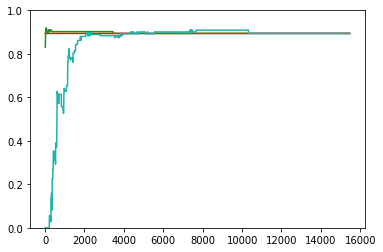

In [56]:
plt.plot(q_u_log, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 1.2.2. Support Vector Machine

In [57]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_svm, iter_u_svm, f1score_u_svm, tn_u_svm, fp_u_svm,fn_u_svm, tp_u_svm, k_u_svm, trn_dss_u_svm, label_holder_u_svm, asked_id_u_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9007633587786259
Current progress: 100.0 %
6794.717520236969


(0, 1)

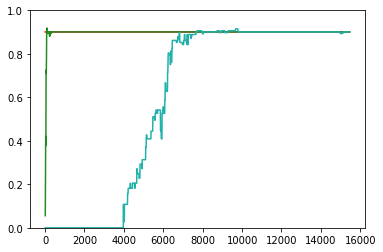

In [58]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_u_svm, 'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

### 1.2.3. Decision Tree

In [59]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_dt, iter_u_dt, f1score_u_dt, tn_u_dt, fp_u_dt,fn_u_dt, tp_u_dt, k_u_dt, trn_dss_u_dt, label_holder_u_dt, asked_id_u_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9402985074626866
Current progress: 100.0 %
1027.8459339141846


(0, 1)

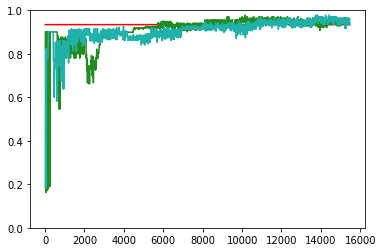

In [60]:
plt.plot(q_u_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_u_dt, f1score_u_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 1.2.4. Random Forest

In [61]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_rf, iter_u_rf, f1score_u_rf, tn_u_rf, fp_u_rf,fn_u_rf, tp_u_rf, k_u_rf, trn_dss_u_rf, label_holder_u_rf, asked_id_u_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9393939393939393
Current progress: 100.0 %
1349.0825431346893


(0, 1)

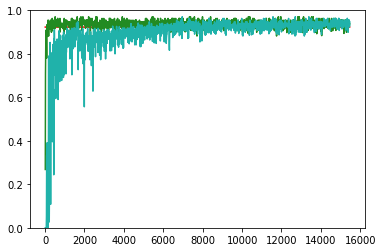

In [62]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_log, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

(all plot)

(0, 1)

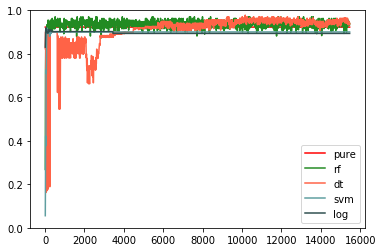

In [63]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_rf, f1score_u_dt, 'tomato')
plt.plot(q_u_rf, f1score_u_svm, 'cadetblue')
plt.plot(q_u_rf, f1score_u_log, 'darkslategray')

plt.legend((('pure','rf','dt','svm','log')),loc='lower right')
#plt.gca().legend(('y0','y1'))


plt.ylim(0, 1)

## 1.3. Query by Committee

In [64]:
q_type='qbc'

### 1.3.1. Mix of all the models

In [65]:
alg='mixall'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
    SklearnProbaAdapter(tree.DecisionTreeClassifier()),
    LogisticRegression(),
    SVM(),])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_mix, iter_qbc_mix, f1score_qbc_mix, tn_qbc_mix, fp_qbc_mix,fn_qbc_mix, tp_qbc_mix, k_qbc_mix, trn_dss_qbc_mix, label_holder_qbc_mix, asked_id_qbc_mix = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8939393939393939
Current progress: 100.0 %
9437.070399045944


(0, 1)

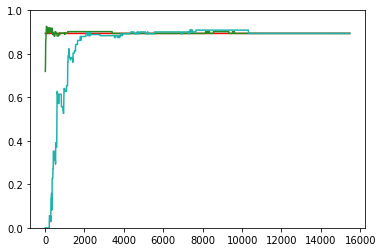

In [66]:
plt.plot(q_qbc_mix, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_mix, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 1.3.2. Only Logistic Regression

In [67]:
alg='onlylog'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    LogisticRegression(C=1.0),
                    LogisticRegression(C=0.1),
                ])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_log, iter_qbc_log, f1score_qbc_log, tn_qbc_log, fp_qbc_log,fn_qbc_log, tp_qbc_log, k_qbc_log, trn_dss_qbc_log, label_holder_qbc_log, asked_id_qbc_log = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8939393939393939
Current progress: 100.0 %
3789.5295100212097


(0, 1)

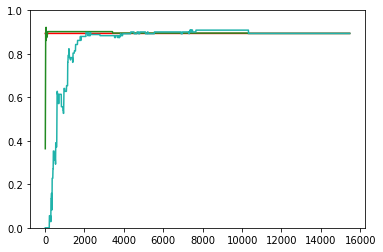

In [68]:
plt.plot(q_qbc_log, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_log, f1score_qbc_log,'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)


### 1.3.3. Only Desicion Tree

In [69]:
alg='onlydt'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='gini')),
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='entropy')),
                ])
model=SklearnProbaAdapter(tree.DecisionTreeClassifier('gini'))
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_dt, iter_qbc_dt, f1score_qbc_dt, tn_qbc_dt, fp_qbc_dt,fn_qbc_dt, tp_qbc_dt, k_qbc_dt, trn_dss_qbc_dt, label_holder_qbc_dt, asked_id_qbc_dt = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9565217391304348
Current progress: 100.0 %
2898.1289818286896


(0, 1)

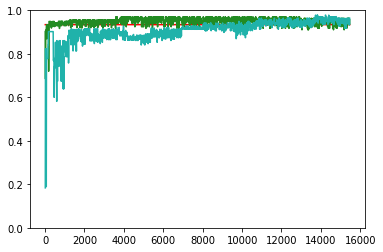

In [70]:
plt.plot(q_qbc_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_dt, f1score_qbc_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 1.3.4. Only Support Vector Machine

In [71]:
alg='onlysvm'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SVM(C=1.0),
                    SVM(C=0.1),
                ])

model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_svc, iter_qbc_svc, f1score_qbc_svc, tn_qbc_svc, fp_qbc_svc,fn_qbc_svc, tp_qbc_svc, k_qbc_svc, trn_dss_qbc_svc, label_holder_qbc_svc, asked_id_qbc_svc = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9007633587786259
Current progress: 100.0 %
13272.44604587555


(0, 1)

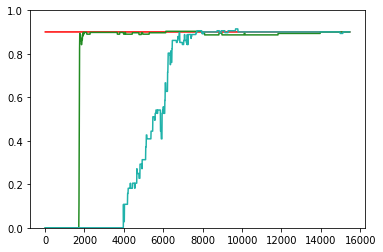

In [72]:
plt.plot(q_qbc_svc, [f1_score_svm] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_svc, f1score_qbc_svc,'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

(all plot)

(0, 1)

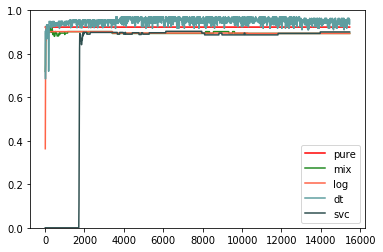

In [73]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_rf, f1score_qbc_log, 'tomato')
plt.plot(q_u_rf, f1score_qbc_dt, 'cadetblue')
plt.plot(q_u_rf, f1score_qbc_svc, 'darkslategray')

plt.legend((('pure','mix','log','dt','svc')),loc='lower right')
#plt.gca().legend(('y0','y1'))


plt.ylim(0, 1)

# 2. USING ONLY LEVENSTEIN

In [74]:
cols = lev_columns_el.copy()
cols.extend(miss_columns)


- Modeling Parameters

In [75]:
# take all the columns
p_result_nomiss_jac=df2[cols_all]
# do train, test split
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)
seed=10
# get the seeds from clusters
samp=get_seed_cluster(y_train, X_train, seed)[0]

# filter the train and test according to its columns
X_train = np.array(pd.DataFrame(X_train).iloc[:,get_columns(cols_all, cols)])
X_test = np.array(pd.DataFrame(X_test).iloc[:,get_columns(cols_all, cols)])

trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds = Dataset(X_test, y_test)


In [76]:
run_=10
missing_option='opt3'
features='onlylev'


- Model Results (pure)

In [77]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log, tn_log, fp_log, fn_log, tp_log = get_base_model_result(y_test, y_train, X_test, X_train, ls())
print(f1_score_log)
print(tn_log)
print(fp_log)
print(fn_log)
print(tp_log)

0.8507462686567163
7542
7
13
57


In [78]:
from sklearn.svm import SVC as support_vector
f1_score_svm, tn_svm, fp_svm, fn_svm, tp_svm = get_base_model_result(y_test, y_train, X_test, X_train, support_vector())
print(f1_score_svm)
print(tn_svm)
print(fp_svm)
print(fn_svm)
print(tp_svm)

0.0
7549
0
70
0


In [79]:
from sklearn import tree
f1_score_dt, tn_dt, fp_dt, fn_dt, tp_dt = get_base_model_result(y_test, y_train, X_test, X_train, tree.DecisionTreeClassifier())
print(f1_score_dt)
print(tn_dt)
print(fp_dt)
print(fn_dt)
print(tp_dt)

0.8531468531468531
7537
12
9
61


In [80]:
f1_score_rf, tn_rf, fp_rf, fn_rf, tp_rf = get_base_model_result(y_test, y_train, X_test, X_train, RandomForestClassifier())
print(f1_score_rf)
print(tn_rf)
print(fp_rf)
print(fn_rf)
print(tp_rf)

0.9104477611940298
7546
3
9
61


## 2.1. Random Sampling

In [81]:
q_type='random'


## 2.1.1. Logistic Regression

In [82]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_log, iter_r_log, f1score_r_log, tn_r_log, fp_r_log,fn_r_log, tp_r_log, k_r_log, trn_dss_r_log, label_holder_r_log, asked_id_r_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8507462686567163
Current progress: 100.0 %
397.1160821914673


(0, 1)

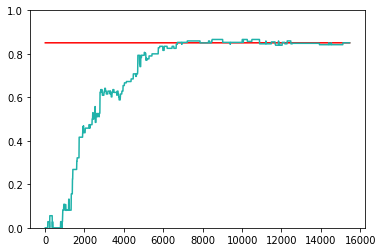

In [83]:
plt.plot(q_r_log, [f1_score_log] * (len(q_r_log)), '-r')
plt.plot(q_r_log, f1score_r_log,'lightseagreen')
plt.ylim(0, 1)

## 2.1.2. Support Vector Machines

In [84]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_svm, iter_r_svm, f1score_r_svm, tn_r_svm, fp_r_svm,fn_r_svm, tp_r_svm, k_r_svm, trn_dss_r_svm, label_holder_r_svm, asked_id_r_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.0
Current progress: 100.0 %
751.8527150154114


(0, 1)

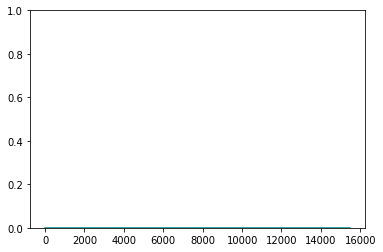

In [85]:
plt.plot(q_r_svm, [f1_score_svm] * (len(q_r_svm)), '-r')
plt.plot(q_r_svm, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)


## 2.1.3. Decision Trees

In [86]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_dt, iter_r_dt, f1score_r_dt, tn_r_dt, fp_r_dt,fn_r_dt, tp_r_dt, k_r_dt, trn_dss_r_dt, label_holder_r_dt, asked_id_r_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8767123287671234
Current progress: 100.0 %
363.2355148792267


(0, 1)

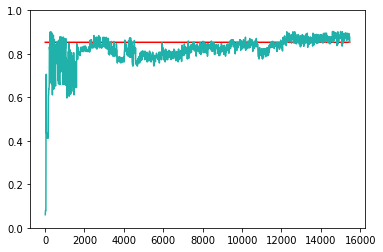

In [87]:
plt.plot(q_r_dt, [f1_score_dt] * (len(q_r_dt)), '-r')
plt.plot(q_r_dt, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)


## 2.1.4. Random Forest Regression

In [88]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_rf, iter_r_rf, f1score_r_rf, tn_r_rf, fp_r_rf,fn_r_rf, tp_r_rf, k_r_rf, trn_dss_r_rf, label_holder_r_rf, asked_id_r_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.880597014925373
Current progress: 100.0 %
383.03611493110657


(0, 1)

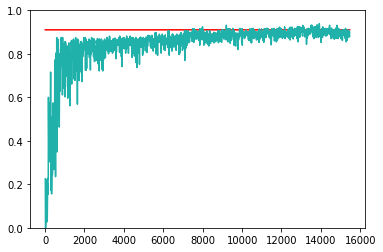

In [89]:
plt.plot(q_r_rf, [f1_score_rf] * (len(q_r_rf)), '-r')
plt.plot(q_r_rf, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

## 2.2. Uncertainity Sampling

In [90]:
q_type='uncertainity'

### 2.2.1. Logistic Regression

In [91]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log, iter_u_log, f1score_u_log, tn_u_log, fp_u_log,fn_u_log, tp_u_log, k_u_log, trn_dss_u_log, label_holder_u_log, asked_id_u_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8507462686567163
Current progress: 100.0 %
1873.4602630138397


(0, 1)

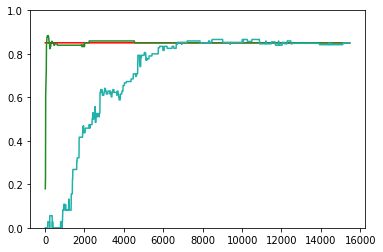

In [92]:
plt.plot(q_u_log, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)


### 2.2.2. Support Vector Machine

In [93]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_svm, iter_u_svm, f1score_u_svm, tn_u_svm, fp_u_svm,fn_u_svm, tp_u_svm, k_u_svm, trn_dss_u_svm, label_holder_u_svm, asked_id_u_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.0
Current progress: 100.0 %
7978.225387096405


(0, 1)

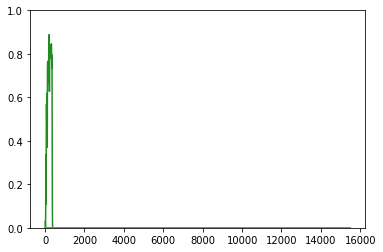

In [94]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_u_svm, 'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

### 2.2.3. Decision Tree

In [95]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_dt, iter_u_dt, f1score_u_dt, tn_u_dt, fp_u_dt,fn_u_dt, tp_u_dt, k_u_dt, trn_dss_u_dt, label_holder_u_dt, asked_id_u_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9027777777777779
Current progress: 100.0 %
1088.1801002025604


(0, 1)

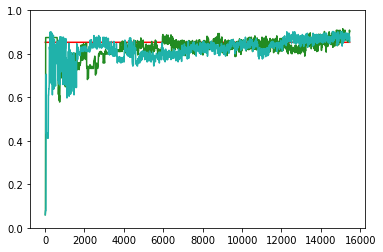

In [96]:
plt.plot(q_u_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_u_dt, f1score_u_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 2.2.4. Random Forest

In [97]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_rf, iter_u_rf, f1score_u_rf, tn_u_rf, fp_u_rf,fn_u_rf, tp_u_rf, k_u_rf, trn_dss_u_rf, label_holder_u_rf, asked_id_u_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9007633587786259
Current progress: 100.0 %
1432.8537800312042


(0, 1)

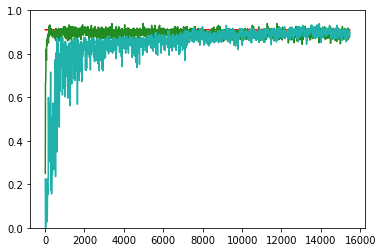

In [98]:

plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_log, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

(all models)

(0, 1)

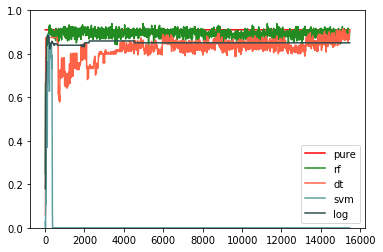

In [99]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_rf, f1score_u_dt, 'tomato')
plt.plot(q_u_rf, f1score_u_svm, 'cadetblue')
plt.plot(q_u_rf, f1score_u_log, 'darkslategray')

plt.legend((('pure','rf','dt','svm','log')),loc='lower right')
#plt.gca().legend(('y0','y1'))
plt.ylim(0, 1)

## 2.3. Query by Committee

In [100]:
q_type='qbc'

### 2.3.1. Mix of all the models

In [101]:
alg='mixall'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
    SklearnProbaAdapter(tree.DecisionTreeClassifier()),
    LogisticRegression(),
    SVM(),])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_mix, iter_qbc_mix, f1score_qbc_mix, tn_qbc_mix, fp_qbc_mix,fn_qbc_mix, tp_qbc_mix, k_qbc_mix, trn_dss_qbc_mix, label_holder_qbc_mix, asked_id_qbc_mix = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8507462686567163
Current progress: 100.0 %
11530.294615983963


(0, 1)

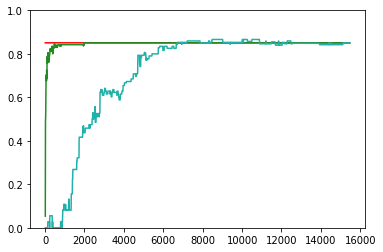

In [102]:
plt.plot(q_qbc_mix, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_mix, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 2.3.2. Only Logistic Regression

In [103]:
alg='onlylog'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    LogisticRegression(C=1.0),
                    LogisticRegression(C=0.1),
                ])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_log, iter_qbc_log, f1score_qbc_log, tn_qbc_log, fp_qbc_log,fn_qbc_log, tp_qbc_log, k_qbc_log, trn_dss_qbc_log, label_holder_qbc_log, asked_id_qbc_log = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8507462686567163
Current progress: 100.0 %
4591.519593954086


(0, 1)

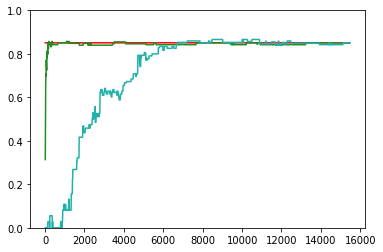

In [104]:
plt.plot(q_qbc_log, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_log, f1score_qbc_log,'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)


### 2.3.3. Only Desicion Tree

In [105]:
alg='onlydt'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='gini')),
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='entropy')),
                ])
model=SklearnProbaAdapter(tree.DecisionTreeClassifier('gini'))
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_dt, iter_qbc_dt, f1score_qbc_dt, tn_qbc_dt, fp_qbc_dt,fn_qbc_dt, tp_qbc_dt, k_qbc_dt, trn_dss_qbc_dt, label_holder_qbc_dt, asked_id_qbc_dt = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8671328671328671
Current progress: 100.0 %
3218.11954498291


(0, 1)

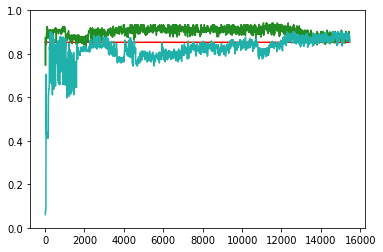

In [106]:
plt.plot(q_qbc_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_dt, f1score_qbc_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 2.3.4. Only Support Vector Machine

In [107]:
alg='onlysvm'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SVM(C=1.0),
                    SVM(C=0.1),
                ])

model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_svc, iter_qbc_svc, f1score_qbc_svc, tn_qbc_svc, fp_qbc_svc,fn_qbc_svc, tp_qbc_svc, k_qbc_svc, trn_dss_qbc_svc, label_holder_qbc_svc, asked_id_qbc_svc = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.0
Current progress: 100.0 %
12706.077548027039


(0, 1)

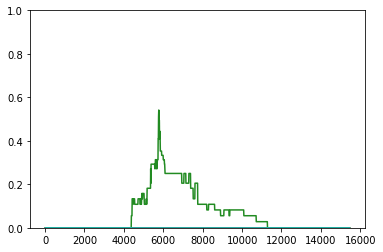

In [108]:
plt.plot(q_qbc_svc, [f1_score_svm] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_svc, f1score_qbc_svc,'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

(all models)

(0, 1)

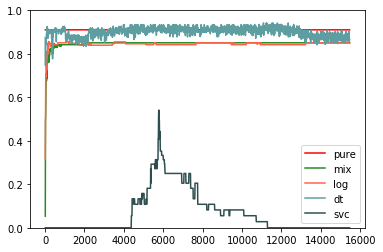

In [109]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_rf, f1score_qbc_log, 'tomato')
plt.plot(q_u_rf, f1score_qbc_dt, 'cadetblue')
plt.plot(q_u_rf, f1score_qbc_svc, 'darkslategray')

plt.legend((('pure','mix','log','dt','svc')),loc='lower right')
#plt.gca().legend(('y0','y1'))


plt.ylim(0, 1)

# 3. USING ONLY JARO-WINKLER

In [110]:
cols = jaro_columns_el.copy()
cols.extend(miss_columns)

- Modeling Parameters

In [111]:
# take all the columns
p_result_nomiss_jac=df2[cols_all]
# do train, test split
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)
seed=10
# get the seeds from clusters
samp=get_seed_cluster(y_train, X_train, seed)[0]

# filter the train and test according to its columns
X_train = np.array(pd.DataFrame(X_train).iloc[:,get_columns(cols_all, cols)])
X_test = np.array(pd.DataFrame(X_test).iloc[:,get_columns(cols_all, cols)])

trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds = Dataset(X_test, y_test)

In [112]:
run_=10
missing_option='opt3'
features='onlyjaro'

- Model Results (pure)

In [113]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log, tn_log, fp_log, fn_log, tp_log = get_base_model_result(y_test, y_train, X_test, X_train, ls())
print(f1_score_log)
print(tn_log)
print(fp_log)
print(fn_log)
print(tp_log)

0.5098039215686275
7543
6
44
26


In [114]:
from sklearn.svm import SVC as support_vector
f1_score_svm, tn_svm, fp_svm, fn_svm, tp_svm = get_base_model_result(y_test, y_train, X_test, X_train, support_vector())
print(f1_score_svm)
print(tn_svm)
print(fp_svm)
print(fn_svm)
print(tp_svm)

0.0
7549
0
70
0


In [115]:
from sklearn import tree
f1_score_dt, tn_dt, fp_dt, fn_dt, tp_dt = get_base_model_result(y_test, y_train, X_test, X_train, tree.DecisionTreeClassifier())
print(f1_score_dt)
print(tn_dt)
print(fp_dt)
print(fn_dt)
print(tp_dt)

0.8936170212765958
7541
8
7
63


In [116]:
f1_score_rf, tn_rf, fp_rf, fn_rf, tp_rf = get_base_model_result(y_test, y_train, X_test, X_train, RandomForestClassifier())
print(f1_score_rf)
print(tn_rf)
print(fp_rf)
print(fn_rf)
print(tp_rf)


0.90625
7549
0
12
58


## 3.1. Random Sampling

In [117]:
q_type='random'

### 3.1.1. Logistic Regression

In [118]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_log, iter_r_log, f1score_r_log, tn_r_log, fp_r_log,fn_r_log, tp_r_log, k_r_log, trn_dss_r_log, label_holder_r_log, asked_id_r_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.5098039215686275
Current progress: 100.0 %
418.8673861026764


(0, 1)

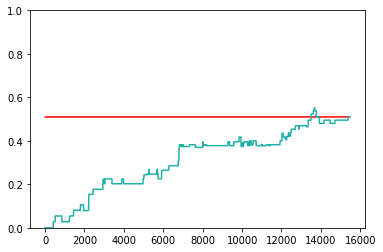

In [119]:
plt.plot(q_r_log, [f1_score_log] * (len(q_r_log)), '-r')
plt.plot(q_r_log, f1score_r_log,'lightseagreen')
plt.ylim(0, 1)


### 3.1.2. Support Vector Machine

In [120]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_svm, iter_r_svm, f1score_r_svm, tn_r_svm, fp_r_svm,fn_r_svm, tp_r_svm, k_r_svm, trn_dss_r_svm, label_holder_r_svm, asked_id_r_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.0
Current progress: 100.0 %
804.4309470653534


(0, 1)

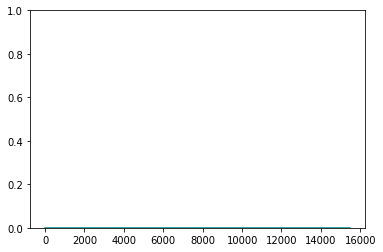

In [121]:
plt.plot(q_r_svm, [f1_score_svm] * (len(q_r_svm)), '-r')
plt.plot(q_r_svm, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)


### 3.1.3. Decision Tree

In [122]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_dt, iter_r_dt, f1score_r_dt, tn_r_dt, fp_r_dt,fn_r_dt, tp_r_dt, k_r_dt, trn_dss_r_dt, label_holder_r_dt, asked_id_r_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9014084507042254
Current progress: 100.0 %
374.56403613090515


(0, 1)

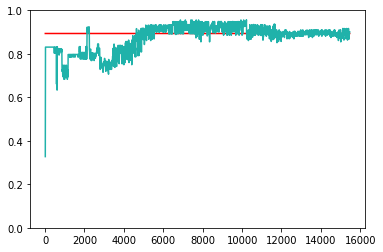

In [123]:
plt.plot(q_r_dt, [f1_score_dt] * (len(q_r_dt)), '-r')
plt.plot(q_r_dt, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)


### 3.1.4. Random Forest

In [124]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_rf, iter_r_rf, f1score_r_rf, tn_r_rf, fp_r_rf,fn_r_rf, tp_r_rf, k_r_rf, trn_dss_r_rf, label_holder_r_rf, asked_id_r_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9076923076923077
Current progress: 100.0 %
394.5767478942871


(0, 1)

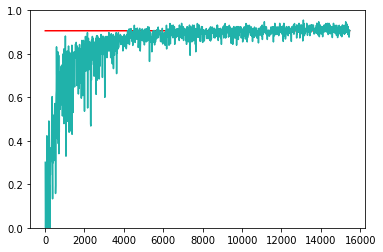

In [125]:
plt.plot(q_r_rf, [f1_score_rf] * (len(q_r_rf)), '-r')
plt.plot(q_r_rf, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)


## 3.2. Uncertainity Sampling

In [126]:
q_type='uncertainity'

### 3.2.1. Logistic Regression

In [127]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log, iter_u_log, f1score_u_log, tn_u_log, fp_u_log,fn_u_log, tp_u_log, k_u_log, trn_dss_u_log, label_holder_u_log, asked_id_u_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.5098039215686275
Current progress: 100.0 %
1963.1244370937347


(0, 1)

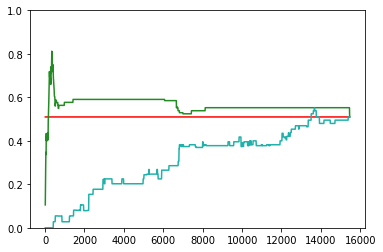

In [128]:
plt.plot(q_u_log, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 3.2.2. Support Vector Machine

In [129]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_svm, iter_u_svm, f1score_u_svm, tn_u_svm, fp_u_svm,fn_u_svm, tp_u_svm, k_u_svm, trn_dss_u_svm, label_holder_u_svm, asked_id_u_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.0
Current progress: 100.0 %
8177.93368601799


(0, 1)

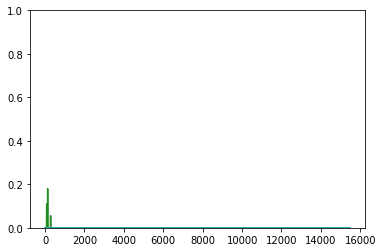

In [130]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_u_svm, 'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

### 3.2.3. Decision Tree

In [131]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_dt, iter_u_dt, f1score_u_dt, tn_u_dt, fp_u_dt,fn_u_dt, tp_u_dt, k_u_dt, trn_dss_u_dt, label_holder_u_dt, asked_id_u_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8695652173913043
Current progress: 100.0 %
1207.432410955429


(0, 1)

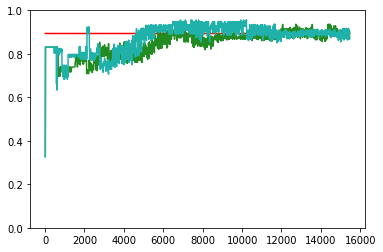

In [132]:
plt.plot(q_u_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_u_dt, f1score_u_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 3.2.4. Random Forest

In [133]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_rf, iter_u_rf, f1score_u_rf, tn_u_rf, fp_u_rf,fn_u_rf, tp_u_rf, k_u_rf, trn_dss_u_rf, label_holder_u_rf, asked_id_u_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9185185185185185
Current progress: 100.0 %
1503.7725610733032


(0, 1)

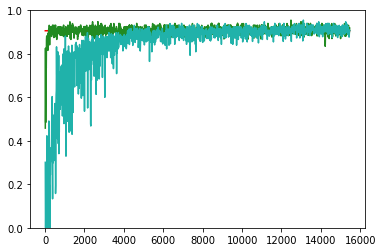

In [134]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_log, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)


(all models)

(0, 1)

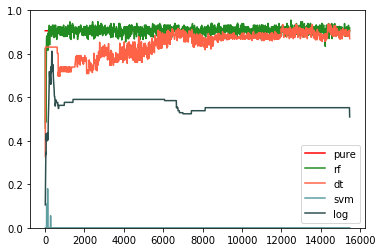

In [135]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_rf, f1score_u_dt, 'tomato')
plt.plot(q_u_rf, f1score_u_svm, 'cadetblue')
plt.plot(q_u_rf, f1score_u_log, 'darkslategray')

plt.legend((('pure','rf','dt','svm','log')),loc='lower right')
#plt.gca().legend(('y0','y1'))
plt.ylim(0, 1)

## 3.3. Query by Committee

In [136]:
q_type='qbc'

### 3.3.1. Mix of all the models

In [137]:
alg='mixall'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
    SklearnProbaAdapter(tree.DecisionTreeClassifier()),
    LogisticRegression(),
    SVM(),])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_mix, iter_qbc_mix, f1score_qbc_mix, tn_qbc_mix, fp_qbc_mix,fn_qbc_mix, tp_qbc_mix, k_qbc_mix, trn_dss_qbc_mix, label_holder_qbc_mix, asked_id_qbc_mix = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.5098039215686275
Current progress: 100.0 %
11872.58780169487


(0, 1)

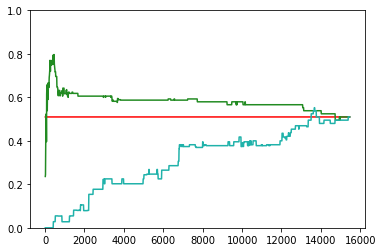

In [138]:
plt.plot(q_qbc_mix, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_mix, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 3.3.2. Only Logistic Regression

In [139]:
alg='onlylog'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    LogisticRegression(C=1.0),
                    LogisticRegression(C=0.1),
                ])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_log, iter_qbc_log, f1score_qbc_log, tn_qbc_log, fp_qbc_log,fn_qbc_log, tp_qbc_log, k_qbc_log, trn_dss_qbc_log, label_holder_qbc_log, asked_id_qbc_log = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.5098039215686275
Current progress: 100.0 %
4526.674387931824


(0, 1)

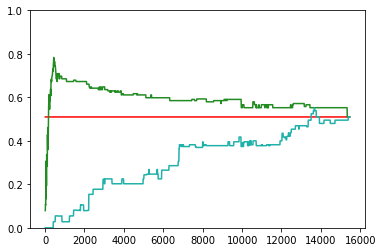

In [140]:
plt.plot(q_qbc_log, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_log, f1score_qbc_log,'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)


### 3.3.3. Only Desicion Tree

In [141]:
alg='onlydt'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='gini')),
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='entropy')),
                ])
model=SklearnProbaAdapter(tree.DecisionTreeClassifier('gini'))
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_dt, iter_qbc_dt, f1score_qbc_dt, tn_qbc_dt, fp_qbc_dt,fn_qbc_dt, tp_qbc_dt, k_qbc_dt, trn_dss_qbc_dt, label_holder_qbc_dt, asked_id_qbc_dt = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8857142857142857
Current progress: 100.0 %
3118.8690588474274


(0, 1)

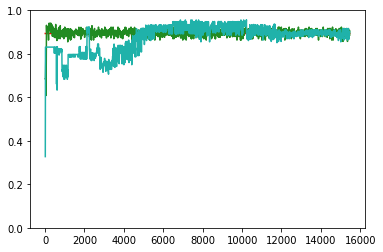

In [142]:
plt.plot(q_qbc_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_dt, f1score_qbc_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 3.3.4. Only Support Vector Machine

In [143]:
alg='onlysvm'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SVM(C=1.0),
                    SVM(C=0.1),
                ])

model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_svc, iter_qbc_svc, f1score_qbc_svc, tn_qbc_svc, fp_qbc_svc,fn_qbc_svc, tp_qbc_svc, k_qbc_svc, trn_dss_qbc_svc, label_holder_qbc_svc, asked_id_qbc_svc = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.0
Current progress: 100.0 %
11599.871496915817


(0, 1)

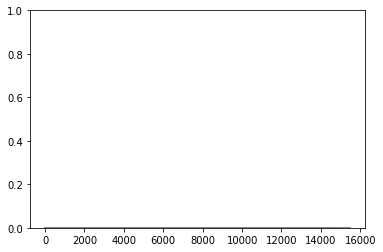

In [144]:
plt.plot(q_qbc_svc, [f1_score_svm] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_svc, f1score_qbc_svc,'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

(all models)

(0, 1)

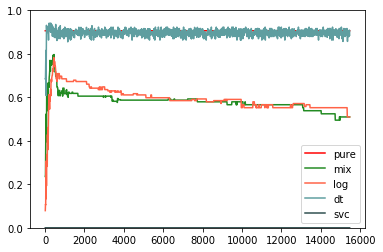

In [145]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_rf, f1score_qbc_log, 'tomato')
plt.plot(q_u_rf, f1score_qbc_dt, 'cadetblue')
plt.plot(q_u_rf, f1score_qbc_svc, 'darkslategray')

plt.legend((('pure','mix','log','dt','svc')),loc='lower right')
#plt.gca().legend(('y0','y1'))


plt.ylim(0, 1)

# 4. ALL FEATURES

In [146]:
run_=10
missing_option='opt3'
features='all'

In [147]:
# take all the columns
p_result_nomiss_jac=df2[cols_all]
# do train, test split
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)
seed=10
# get the seeds from clusters
samp=get_seed_cluster(y_train, X_train, seed)[0]

trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds = Dataset(X_test, y_test)


- Model Results (pure)

In [148]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log, tn_log, fp_log, fn_log, tp_log = get_base_model_result(y_test, y_train, X_test, X_train, ls())
print(f1_score_log)
print(tn_log)
print(fp_log)
print(fn_log)
print(tp_log)

0.8955223880597014
7545
4
10
60


In [149]:
from sklearn.svm import SVC as support_vector
f1_score_svm, tn_svm, fp_svm, fn_svm, tp_svm = get_base_model_result(y_test, y_train, X_test, X_train, support_vector())
print(f1_score_svm)
print(tn_svm)
print(fp_svm)
print(fn_svm)
print(tp_svm)

0.8923076923076922
7547
2
12
58


In [150]:
from sklearn import tree
f1_score_dt, tn_dt, fp_dt, fn_dt, tp_dt = get_base_model_result(y_test, y_train, X_test, X_train, tree.DecisionTreeClassifier())
print(f1_score_dt)
print(tn_dt)
print(fp_dt)
print(fn_dt)
print(tp_dt)

0.9361702127659575
7544
5
4
66


In [151]:
f1_score_rf, tn_rf, fp_rf, fn_rf, tp_rf = get_base_model_result(y_test, y_train, X_test, X_train, RandomForestClassifier())
print(f1_score_rf)
print(tn_rf)
print(fp_rf)
print(fn_rf)
print(tp_rf)

0.9402985074626866
7548
1
7
63


## 4.1. Random Sampling

In [152]:
q_type='random'

## 4.1.1. Logistic Regression

In [153]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_log, iter_r_log, f1score_r_log, tn_r_log, fp_r_log,fn_r_log, tp_r_log, k_r_log, trn_dss_r_log, label_holder_r_log, asked_id_r_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8955223880597014
Current progress: 100.0 %
427.02243399620056


(0, 1)

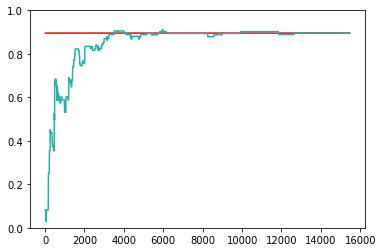

In [154]:
plt.plot(q_u_svm, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_log,'lightseagreen')
plt.ylim(0, 1)

## 4.1.2. Support Vector Machines

In [155]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_svm, iter_r_svm, f1score_r_svm, tn_r_svm, fp_r_svm,fn_r_svm, tp_r_svm, k_r_svm, trn_dss_r_svm, label_holder_r_svm, asked_id_r_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8923076923076922
Current progress: 100.0 %
1058.2242550849915


(0, 1)

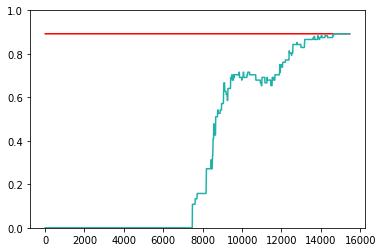

In [156]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)


## 4.1.3. Decision Trees

In [157]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_dt, iter_r_dt, f1score_r_dt, tn_r_dt, fp_r_dt,fn_r_dt, tp_r_dt, k_r_dt, trn_dss_r_dt, label_holder_r_dt, asked_id_r_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9370629370629371
Current progress: 100.0 %
504.6009941101074


(0, 1)

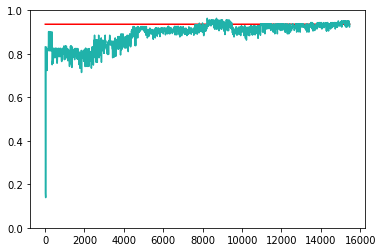

In [158]:
plt.plot(q_u_svm, [f1_score_dt] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)


## 4.1.4. Random Forest Regression

In [159]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_rf, iter_r_rf, f1score_r_rf, tn_r_rf, fp_r_rf,fn_r_rf, tp_r_rf, k_r_rf, trn_dss_r_rf, label_holder_r_rf, asked_id_r_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9333333333333333
Current progress: 100.0 %
446.4938519001007


(0, 1)

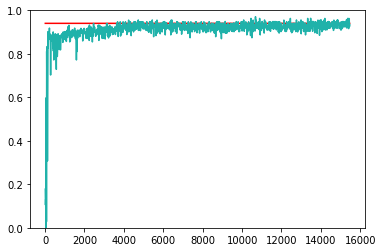

In [160]:
plt.plot(q_u_svm, [f1_score_rf] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

## 4.2. Uncertainity Sampling

In [161]:
q_type='uncertainity'

### 4.2.1. Logistic Regression

In [162]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log, iter_u_log, f1score_u_log, tn_u_log, fp_u_log,fn_u_log, tp_u_log, k_u_log, trn_dss_u_log, label_holder_u_log, asked_id_u_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8955223880597014
Current progress: 100.0 %
2015.6833012104034


(0, 1)

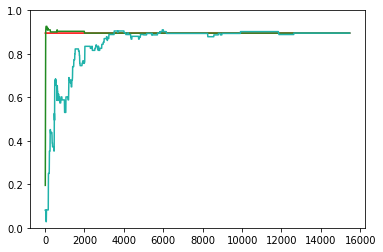

In [163]:
plt.plot(q_u_log, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 4.2.2. Support Vector Machine

In [164]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_svm, iter_u_svm, f1score_u_svm, tn_u_svm, fp_u_svm,fn_u_svm, tp_u_svm, k_u_svm, trn_dss_u_svm, label_holder_u_svm, asked_id_u_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8923076923076922
Current progress: 100.0 %
13085.957746982574


(0, 1)

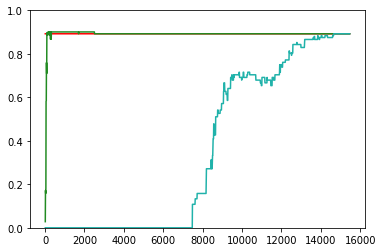

In [165]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_u_svm, 'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

### 4.2.3. Decision Tree

In [166]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_dt, iter_u_dt, f1score_u_dt, tn_u_dt, fp_u_dt,fn_u_dt, tp_u_dt, k_u_dt, trn_dss_u_dt, label_holder_u_dt, asked_id_u_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9379310344827586
Current progress: 100.0 %
3142.217164993286


(0, 1)

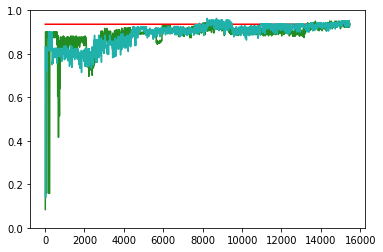

In [167]:
plt.plot(q_u_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_u_dt, f1score_u_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 4.2.4. Random Forest

In [168]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_rf, iter_u_rf, f1score_u_rf, tn_u_rf, fp_u_rf,fn_u_rf, tp_u_rf, k_u_rf, trn_dss_u_rf, label_holder_u_rf, asked_id_u_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9007633587786259
Current progress: 100.0 %
2041.4153561592102


(0, 1)

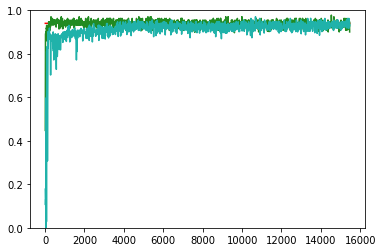

In [169]:

plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_log, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

(all models)

(0, 1)

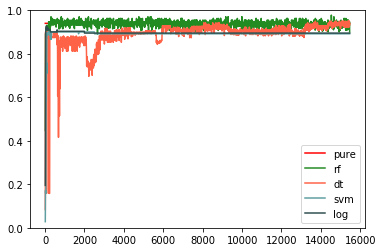

In [170]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_rf, f1score_u_dt, 'tomato')
plt.plot(q_u_rf, f1score_u_svm, 'cadetblue')
plt.plot(q_u_rf, f1score_u_log, 'darkslategray')

plt.legend((('pure','rf','dt','svm','log')),loc='lower right')
#plt.gca().legend(('y0','y1'))
plt.ylim(0, 1)

## 4.3. Query by Committee

In [171]:
q_type='qbc'

### 4.3.1. Mix of all the models

In [172]:
alg='mixall'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
    SklearnProbaAdapter(tree.DecisionTreeClassifier()),
    LogisticRegression(),
    SVM(),])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_mix, iter_qbc_mix, f1score_qbc_mix, tn_qbc_mix, fp_qbc_mix,fn_qbc_mix, tp_qbc_mix, k_qbc_mix, trn_dss_qbc_mix, label_holder_qbc_mix, asked_id_qbc_mix = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8955223880597014
Current progress: 100.0 %
18577.345699071884


(0, 1)

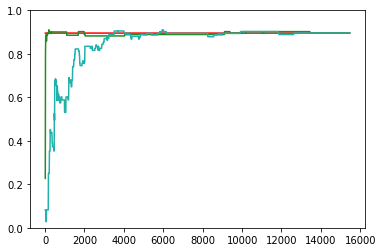

In [173]:
plt.plot(q_qbc_mix, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_mix, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 4.3.2. Only Logistic Regression

In [174]:
alg='onlylog'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    LogisticRegression(C=1.0),
                    LogisticRegression(C=0.1),
                ])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_log, iter_qbc_log, f1score_qbc_log, tn_qbc_log, fp_qbc_log,fn_qbc_log, tp_qbc_log, k_qbc_log, trn_dss_qbc_log, label_holder_qbc_log, asked_id_qbc_log = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8955223880597014
Current progress: 100.0 %
5192.925707101822


(0, 1)

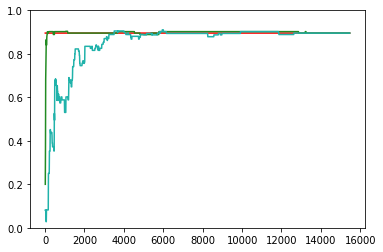

In [175]:
plt.plot(q_qbc_log, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_log, f1score_qbc_log,'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)


### 4.3.3. Only Desicion Tree

In [176]:
alg='onlydt'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='gini')),
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='entropy')),
                ])
model=SklearnProbaAdapter(tree.DecisionTreeClassifier('gini'))
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_dt, iter_qbc_dt, f1score_qbc_dt, tn_qbc_dt, fp_qbc_dt,fn_qbc_dt, tp_qbc_dt, k_qbc_dt, trn_dss_qbc_dt, label_holder_qbc_dt, asked_id_qbc_dt = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9370629370629371
Current progress: 100.0 %
4526.747565984726


(0, 1)

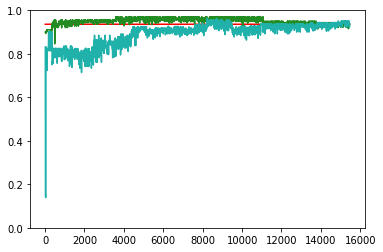

In [177]:
plt.plot(q_qbc_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_dt, f1score_qbc_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 4.3.4. Only Support Vector Machine

In [178]:
alg='onlysvm'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SVM(C=1.0),
                    SVM(C=0.1),
                ])

model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_svc, iter_qbc_svc, f1score_qbc_svc, tn_qbc_svc, fp_qbc_svc,fn_qbc_svc, tp_qbc_svc, k_qbc_svc, trn_dss_qbc_svc, label_holder_qbc_svc, asked_id_qbc_svc = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8923076923076922
Current progress: 100.0 %
24335.436768054962


(0, 1)

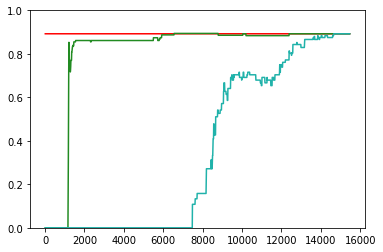

In [179]:
plt.plot(q_qbc_svc, [f1_score_svm] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_svc, f1score_qbc_svc,'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

(all models)

(0, 1)

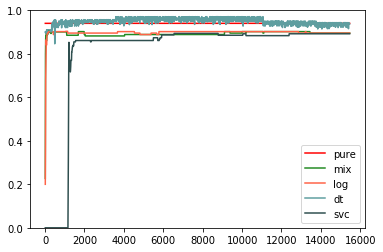

In [180]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_rf, f1score_qbc_log, 'tomato')
plt.plot(q_u_rf, f1score_qbc_dt, 'cadetblue')
plt.plot(q_u_rf, f1score_qbc_svc, 'darkslategray')

plt.legend((('pure','mix','log','dt','svc')),loc='lower right')
#plt.gca().legend(('y0','y1'))


plt.ylim(0, 1)

# 5. FEATURE SELECTION

- Modeling Parameters

In [23]:
run_=10
missing_option='opt3'
features='fetselect'

In [24]:
# take all the columns
p_result_nomiss_jac=df2[cols_all]
# do train, test split
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)
seed=10
# get the seeds from clusters
samp=get_seed_cluster(y_train, X_train, seed)[0]

trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds = Dataset(X_test, y_test)


- Model results (choose features) -> F-Classification

In [25]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif


X_new = SelectKBest(f_classif, k=20).fit(X_train, y_train)
mask = X_new.get_support() #list of booleans
new_features_f = [] # The list of your K best features

for bool, feature in zip(mask, cols_all):
    if bool:
        new_features_f.append(feature)

col_index=[cols_all.index(i) for i in new_features_f]
X_test_feature=[i[col_index] for i in X_test]
X_train_feature=[i[col_index] for i in X_train]

In [26]:
new_features_f

['jac_model',
 'jac_brand',
 'jac_included_accessories',
 'jac_impedance',
 'jac_frequency_response',
 'jac_mpn',
 'jac_headphones_cup_type',
 'jac_microphone_sensitivity',
 'jac_sensitivity',
 'lev_model',
 'lev_brand',
 'lev_thd',
 'lev_included_accessories',
 'lev_impedance',
 'lev_mpn',
 'lev_headphones_cup_type',
 'jaro_model',
 'jaro_brand',
 'jaro_mpn',
 'jaro_headphones_cup_type']

In [27]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log_fclass, tn_log_fclass, fp_log_fclass, fn_log_fclass, tp_log_fclass = get_base_model_result(y_test, y_train, X_test_feature, X_train_feature, ls())
print(f1_score_log_fclass)
print(tn_log_fclass)
print(fp_log_fclass)
print(fn_log_fclass)
print(tp_log_fclass)

0.8939393939393939
7546
3
11
59


In [28]:
from sklearn.svm import SVC as support_vector
f1_score_svm_fclass, tn_svm_fclass, fp_svm_fclass, fn_svm_fclass, tp_svm_fclass = get_base_model_result(y_test, y_train, X_test_feature, X_train_feature, support_vector())
print(f1_score_svm_fclass)
print(tn_svm_fclass)
print(fp_svm_fclass)
print(fn_svm_fclass)
print(tp_svm_fclass)

0.909090909090909
7547
2
10
60


In [29]:
from sklearn import tree
f1_score_dt_fclass, tn_dt_fclass, fp_dt_fclass, fn_dt_fclass, tp_dt_fclass = get_base_model_result(y_test, y_train, X_test_feature, X_train_feature, tree.DecisionTreeClassifier())
print(f1_score_dt_fclass)
print(tn_dt_fclass)
print(fp_dt_fclass)
print(fn_dt_fclass)
print(tp_dt_fclass)

0.9361702127659575
7544
5
4
66


In [30]:
f1_score_rf_fclass, tn_rf_fclass, fp_rf_fclass, fn_rf_fclass, tp_rf_fclass = get_base_model_result(y_test, y_train, X_test_feature, X_train_feature, RandomForestClassifier())
print(f1_score_rf_fclass)
print(tn_rf_fclass)
print(fp_rf_fclass)
print(fn_rf_fclass)
print(tp_rf_fclass)

0.9393939393939393
7549
0
8
62


## 5.1. Random Sampling

In [31]:
q_type='random'

In [32]:
run_

10

### 5.1.1. Logistic Regression

In [33]:
alg='log'
model_ = LogisticRegression()
method_='lc'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method=method_, model=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_log, iter_r_log, f1score_r_log, tn_r_log, fp_r_log,fn_r_log, tp_r_log, k_r_log, trn_dss_r_log, label_holder_r_log, asked_id_r_log, featur_log_r = run_featureselection(trn_ds, tst_ds, y_train, model_, method_, qs, X_test, y_test, cols_all, name,True,'random', run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
iteration: 1545
1546
train dataset labeled: 15468
train dataset shape: (15468, 104)
train dataset sum: 194
Current f1 score: 0.8939393939393939
Current progress: 100.0 %
Chosen_features: ['jac_model', 'jac_brand', 'jac_included_accessories', 'jac_impedance', 'jac_frequency_response', 'jac_mpn', 'jac_headphones_cup_type', 'jac_microphone_sensitivity', 'jac_sensitivity', 'lev_model', 'lev_brand', 'lev_thd', 'lev_included_accessories', 'lev_impedance', 'lev_mpn', 'lev_headphones_cup_type', 'jaro_model', 'jaro_brand', 'jaro_mpn', 'jaro_headphones_cup_type']
671.3249008655548


(0, 1)

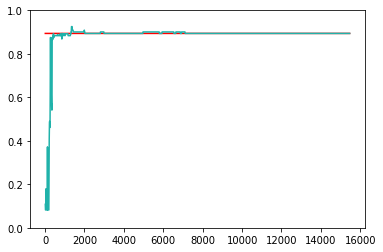

In [34]:
plt.plot(q_r_log, [f1_score_log_fclass] * (len(q_r_log)), '-r')
plt.plot(q_r_log, f1score_r_log,'lightseagreen')
plt.ylim(0, 1)

### 5.1.2. Support Vector Machine

In [35]:
alg='svm'
model_ = SVM()
method_='lc'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method=method_, model=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_svm, iter_r_svm, f1score_r_svm, tn_r_svm, fp_r_svm,fn_r_svm, tp_r_svm, k_r_svm, trn_dss_r_svm, label_holder_r_svm, asked_id_r_svm, featur_r_svm = run_featureselection(trn_ds, tst_ds, y_train, model_, method_, qs, X_test, y_test, cols_all, name,True,'random', run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
iteration: 1545
1546
train dataset labeled: 15468
train dataset shape: (15468, 104)
train dataset sum: 194
Current f1 score: 0.909090909090909
Current progress: 100.0 %
Chosen_features: ['jac_model', 'jac_brand', 'jac_included_accessories', 'jac_impedance', 'jac_frequency_response', 'jac_mpn', 'jac_headphones_cup_type', 'jac_microphone_sensitivity', 'jac_sensitivity', 'lev_model', 'lev_brand', 'lev_thd', 'lev_included_accessories', 'lev_impedance', 'lev_mpn', 'lev_headphones_cup_type', 'jaro_model', 'jaro_brand', 'jaro_mpn', 'jaro_headphones_cup_type']
821.1153359413147


(0, 1)

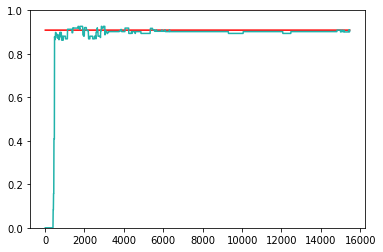

In [36]:
plt.plot(q_r_svm, [f1_score_svm_fclass] * (len(q_r_svm)), '-r')
plt.plot(q_r_svm, f1score_r_svm,'lightseagreen')
plt.ylim(0, 1)

## 5.2. Uncertainty Sampling

In [37]:
q_type='uncertainity'

### 5.2.1. Logistic Regression

In [38]:
alg='log'
model_ = LogisticRegression()
method_='lc'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method=method_, model=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log, iter_u_log, f1score_u_log, tn_u_log, fp_u_log,fn_u_log, tp_u_log, k_u_log, trn_dss_u_log, label_holder_u_log, asked_id_u_log, featur_log_u = run_featureselection(trn_ds, tst_ds, y_train, model_,method_, qs, X_test, y_test,cols_all,name,True,'unc',run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
iteration: 1545
1546
train dataset labeled: 15468
train dataset shape: (15468, 104)
train dataset sum: 194
Current f1 score: 0.8939393939393939
Current progress: 100.0 %
Chosen_features: ['jac_model', 'jac_brand', 'jac_included_accessories', 'jac_impedance', 'jac_frequency_response', 'jac_mpn', 'jac_headphones_cup_type', 'jac_microphone_sensitivity', 'jac_sensitivity', 'lev_model', 'lev_brand', 'lev_thd', 'lev_included_accessories', 'lev_impedance', 'lev_mpn', 'lev_headphones_cup_type', 'jaro_model', 'jaro_brand', 'jaro_mpn', 'jaro_headphones_cup_type']
1356.1204648017883


(0, 1)

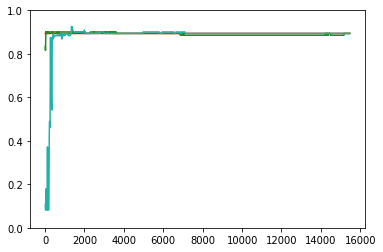

In [39]:
plt.plot(q_u_log, [f1_score_log_fclass] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 5.2.2. Support Vector Machine

In [40]:
alg='svm'
model_=SVM()
method_='lc'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method=method_, model=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_svm, iter_u_svm, f1score_u_svm, tn_u_svm, fp_u_svm,fn_u_svm, tp_u_svm, k_u_svm, trn_dss_u_svm, label_holder_u_svm, asked_id_u_svm, featur_log_svm = run_featureselection(trn_ds, tst_ds, y_train, model_,method_, qs, X_test, y_test,cols_all,name,True,'unc',run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
iteration: 1545
1546
train dataset labeled: 15468
train dataset shape: (15468, 104)
train dataset sum: 194
Current f1 score: 0.909090909090909
Current progress: 100.0 %
Chosen_features: ['jac_model', 'jac_brand', 'jac_included_accessories', 'jac_impedance', 'jac_frequency_response', 'jac_mpn', 'jac_headphones_cup_type', 'jac_microphone_sensitivity', 'jac_sensitivity', 'lev_model', 'lev_brand', 'lev_thd', 'lev_included_accessories', 'lev_impedance', 'lev_mpn', 'lev_headphones_cup_type', 'jaro_model', 'jaro_brand', 'jaro_mpn', 'jaro_headphones_cup_type']
3197.944398164749


(0, 1)

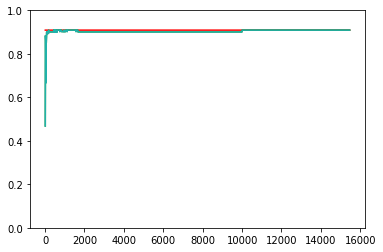

In [41]:
plt.plot(q_u_svm, [f1_score_svm_fclass] * (len(q_u_svm)), '-r')
plt.plot(q_u_svm, f1score_u_svm, 'forestgreen')
plt.plot(q_u_svm, f1score_u_svm, 'lightseagreen')
plt.ylim(0, 1)


## 5.3. Query by Committee

In [42]:
q_type='qbc'

### 5.3.1. Mix of all the models

In [43]:
alg='mixall'
model_= [SklearnProbaAdapter(tree.DecisionTreeClassifier()),
    LogisticRegression(),
    SVM()]
method_=LogisticRegression()
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_mix, iter_qbc_mix, f1score_qbc_mix, tn_qbc_mix, fp_qbc_mix,fn_qbc_mix, tp_qbc_mix, k_qbc_mix, trn_dss_qbc_mix, label_holder_qbc_mix, asked_id_qbc_mix, featur_log_qbc = run_featureselection(trn_ds, tst_ds, y_train, model_,method_, qs,X_test, y_test,cols_all,name,True,'qbc',run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
iteration: 1545
1546
train dataset labeled: 15468
train dataset shape: (15468, 104)
train dataset sum: 194
Current f1 score: 0.8939393939393939
Current progress: 100.0 %
Chosen_features: ['jac_model', 'jac_brand', 'jac_included_accessories', 'jac_impedance', 'jac_frequency_response', 'jac_mpn', 'jac_headphones_cup_type', 'jac_microphone_sensitivity', 'jac_sensitivity', 'lev_model', 'lev_brand', 'lev_thd', 'lev_included_accessories', 'lev_impedance', 'lev_mpn', 'lev_headphones_cup_type', 'jaro_model', 'jaro_brand', 'jaro_mpn', 'jaro_headphones_cup_type']
17346.656143188477


(0, 1)

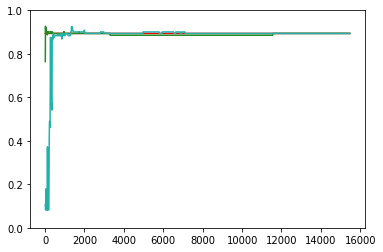

In [44]:
plt.plot(q_qbc_mix, [f1_score_log_fclass] * (len(q_qbc_mix)), '-r')
plt.plot(q_qbc_mix, f1score_qbc_mix, 'forestgreen')
plt.plot(q_qbc_mix, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 5.4.2. Only Logistic Regression

In [45]:
alg='log'
model_= [LogisticRegression(C=1.0),
        LogisticRegression(C=0.1)]
method_=LogisticRegression()
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_log, iter_qbc_log, f1score_qbc_log, tn_qbc_log, fp_qbc_log,fn_qbc_log, tp_qbc_log, k_qbc_log, trn_dss_qbc_log, label_holder_qbc_log, asked_id_qbc_log, featur_loglog_qbc = run_featureselection(trn_ds, tst_ds, y_train, model_, method_,qs,X_test, y_test,cols_all,name,True,'qbc',run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
iteration: 1545
1546
train dataset labeled: 15468
train dataset shape: (15468, 104)
train dataset sum: 194
Current f1 score: 0.8939393939393939
Current progress: 100.0 %
Chosen_features: ['jac_model', 'jac_brand', 'jac_included_accessories', 'jac_impedance', 'jac_frequency_response', 'jac_mpn', 'jac_headphones_cup_type', 'jac_microphone_sensitivity', 'jac_sensitivity', 'lev_model', 'lev_brand', 'lev_thd', 'lev_included_accessories', 'lev_impedance', 'lev_mpn', 'lev_headphones_cup_type', 'jaro_model', 'jaro_brand', 'jaro_mpn', 'jaro_headphones_cup_type']
7585.450136184692


(0, 1)

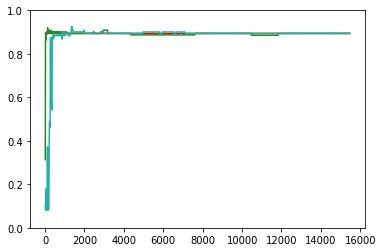

In [46]:
plt.plot(q_qbc_log, [f1_score_log_fclass] * (len(q_qbc_log)), '-r')
plt.plot(q_qbc_log, f1score_qbc_log, 'forestgreen')
plt.plot(q_qbc_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 5.4.3. Only Support Vector Machine

In [47]:
alg='svm'
model_= [SVM(C=1.0),
         SVM(C=0.1)]
method_=SVM()
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_svc, iter_qbc_svc, f1score_qbc_svc, tn_qbc_svc, fp_qbc_svc,fn_qbc_svc, tp_qbc_svc, k_qbc_svc, trn_dss_qbc_svc, label_holder_qbc_svc, asked_id_qbc_svc, featur_svm_qbc = run_featureselection(trn_ds, tst_ds, y_train, model_, method_, qs, X_test, y_test,cols_all,name,True,'qbc',run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
iteration: 1545
1546
train dataset labeled: 15468
train dataset shape: (15468, 104)
train dataset sum: 194
Current f1 score: 0.909090909090909
Current progress: 100.0 %
Chosen_features: ['jac_model', 'jac_brand', 'jac_included_accessories', 'jac_impedance', 'jac_frequency_response', 'jac_mpn', 'jac_headphones_cup_type', 'jac_microphone_sensitivity', 'jac_sensitivity', 'lev_model', 'lev_brand', 'lev_thd', 'lev_included_accessories', 'lev_impedance', 'lev_mpn', 'lev_headphones_cup_type', 'jaro_model', 'jaro_brand', 'jaro_mpn', 'jaro_headphones_cup_type']
23666.070417165756


(0, 1)

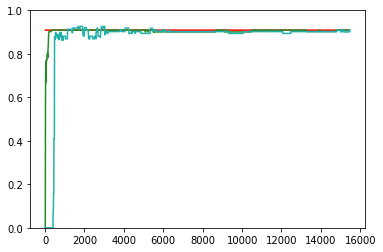

In [48]:
plt.plot(q_qbc_svc, [f1_score_svm_fclass] * (len(q_qbc_log)), '-r')
plt.plot(q_qbc_svc, f1score_qbc_svc, 'forestgreen')
plt.plot(q_qbc_svc, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)